# ML4N - Group Project 7
# Analysing Adversarial Attacks on Tabular Data Classifiers

In [2]:
# import needed python libraries

#%pip install -r requirements.txt

import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D 


import torch # type: ignore
import torch.nn.functional as F
import random

import plotly.offline as py 
import plotly.express as px
import plotly.graph_objs as go # it's like "plt" of matplot
import plotly.subplots as tls # It's useful to we get some tools of plotly


# Change the default font family
rcParams['font.family'] = 'DejaVu Sans'

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from plotly.subplots import make_subplots
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay, balanced_accuracy_score, silhouette_score, adjusted_rand_score, rand_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils._testing import ignore_warnings
from art.estimators.classification import PyTorchClassifier # type: ignore
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent # type: ignore
from collections import Counter # To do counter of some features
from torch import nn
from imblearn.over_sampling import SMOTE # type: ignore

from scipy.stats import uniform
from xgboost import XGBClassifier

#### this code, allow us to work with offline plotly version
py.init_notebook_mode(connected=True) 

#### to avoid some redundant warning during cross-validation due to parameters incompatibility and also eventual packets'versions mismatch
import warnings
warnings.filterwarnings('ignore')

# matplotlib defaults
plt.style.use("fivethirtyeight")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
    grid=True,
)


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [1]:
# confusion matrix
def confusion_matri(actual, predicted):
    cm = confusion_matrix(actual, predicted, labels=[1,0])
    tp, fp, fn, tn = cm.ravel()
    #plot confusion matrix
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='.2f', 
                xticklabels =['Bad credit','Good credit'],
                yticklabels =['Bad credit','Good credit'])
    plt.ylabel('True Label')
    plt.xlabel('Predicted lable')
    plt.title("Confusion Matrix")
    plt.show()
    return tn,fp,fn,tp

# plotting roc-auc curve
def draw_roc(actual, proba):
    fpr, tpr, thresholds = roc_curve(actual, proba,drop_intermediate=False)
    auc_score = roc_auc_score(actual, proba)
    # plot the curve
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label="ROC curve(area={})".format(round(auc_score,2)))
    plt.plot([0,1],[0,1], 'k--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid(visible=True, color='wheat', linestyle='--')
    plt.legend(loc="lower right")
    plt.title("ROC-AUC Curve")
    plt.show()
    return fpr, tpr, thresholds

# 1 Data exploration and preprocessing

## 1.1 Dataset Acquisition ###

---
Begin by downloading the [German Credit Risk dataset](https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data)

In [3]:
#### List of Attributes for dataset acquired from german.doc
#### good/bad is the label 1 means good customer while 2 means bad
attributes = ["Status_account", "Duration", "Credit_history","Purpose",
             "Credit_amount","Savings_account_bonds","Employment_since","Install_rate",
              "Personal_status_sex","debtors_guarantors","Present_residence_since",
              "Property","Age","Other_install_plans","Housing","No_credits","Job",
              "No_people_liable","Telephone","foreign_worker","good_bad"] 

#### Acquiring dataset from german.data file
df = pd.read_csv("statlog+german+credit+data/german.data", sep=' ', names = attributes)
df

,Status_account,Duration,Credit_history,Purpose,Credit_amount,Savings_account_bonds,Employment_since,Install_rate,Personal_status_sex,debtors_guarantors,...,Property,Age,Other_install_plans,Housing,No_credits,Job,No_people_liable,Telephone,foreign_worker,good_bad
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,A14,12,A32,A42,1736,A61,A74,3,A92,A101,...,A121,31,A143,A152,1,A172,1,A191,A201,1
996,A11,30,A32,A41,3857,A61,A73,4,A91,A101,...,A122,40,A143,A152,1,A174,1,A192,A201,1
997,A14,12,A32,A43,804,A61,A75,4,A93,A101,...,A123,38,A143,A152,1,A173,1,A191,A201,1
998,A11,45,A32,A43,1845,A61,A73,4,A93,A101,...,A124,23,A143,A153,1,A173,1,A192,A201,2


### We create a hard copy To use in the visualization part.

In [4]:
df_credit = df.copy()

### The dataset

The dataset is composed of both categorical and numerical features which are used to describe the socio-economic situation of the credit applicants, the categorical ones are codified with alpha numerical codes.As an example we report the meaning of some of the features of the dataset

**Existing Checking Account (Qualitative)**

Status of existing checking account i.e. range of money in existing checking account (if present)

| Value | Description|
| --- | --- |
| A11 | .. < 0 DM | 
| A12 | 0 <= ... < 200 DM | 
| A13 | ... >= 200 DM / salary assignments for at least 1 year |
| A14 | no checking account|

Note: DM stands for Deutsche Marks.

**Month Duration (Numerical)**

Duration in month of the asked loan

**Purpose (Qualitative)**

Purpose of the requested loan

| Value | Description|
| --- | --- |
| A40 | car (new)
| A41 | car (used)
| A42 | furniture/equipment
| A43 | radio/television
| A44 | domestic appliances
| A45 | repairs
| A46 | education
| A47 | vacation
| A48 | retraining
| A49 | business
| A410 | others

**Credit Amount (Numerical)**

Amount of money requested for the credit

**Personal Status and Sex (Qualitative)**

| Value | Description|
| --- | --- |
|A91 | male : divorced/separated
|A92 | female : divorced/separated/married
|A93 | male : single
|A94 | male : married/widowed
|A95 | female : single

**Property (Qualitative)**

Type of property owned by the applicant

| Value | Description|
| --- | --- |
|A121 | real estate
|A122 | if not A121 : building society savings agreement/ life insurance
|A123 | if not A121/A122 : car or other, not in attribute 6
|A124 | unknown / no property

**Age (Numerical)**

Age in years

**Housing (Qualitative)**

| Value | Description|
| --- | --- |
|A151 | rent
|A152 | own
|A153 | for free

**Existing credit number (Numerical)**

Number of existing credit at this bank

**Result (Response)**

| Value | Description|
| --- | --- |
|1 | good (applicant eligible for credit)
|2 | bad (applicant not eligible for credit)

As we can see the value used for describing the response are $1 \implies good$ result and $2 \implies bad$ result. 

With df.info() we can find if some data are missing

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Status_account           1000 non-null   object
 1   Duration                 1000 non-null   int64 
 2   Credit_history           1000 non-null   object
 3   Purpose                  1000 non-null   object
 4   Credit_amount            1000 non-null   int64 
 5   Savings_account_bonds    1000 non-null   object
 6   Employment_since         1000 non-null   object
 7   Install_rate             1000 non-null   int64 
 8   Personal_status_sex      1000 non-null   object
 9   debtors_guarantors       1000 non-null   object
 10  Present_residence_since  1000 non-null   int64 
 11  Property                 1000 non-null   object
 12  Age                      1000 non-null   int64 
 13  Other_install_plans      1000 non-null   object
 14  Housing                  1000 non-null   

With the describe method we can see some basics statistics about the quantitative features

In [6]:
df.describe()

,Duration,Credit_amount,Install_rate,Present_residence_since,Age,No_credits,No_people_liable,good_bad
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000,1.300000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086,0.458487
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000,2.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000,2.000000


In [7]:
#Looking unique values
print(df.nunique())

Status_account               4
Duration                    33
Credit_history               5
Purpose                     10
Credit_amount              921
Savings_account_bonds        5
Employment_since             5
Install_rate                 4
Personal_status_sex          4
debtors_guarantors           3
Present_residence_since      4
Property                     4
Age                         53
Other_install_plans          3
Housing                      3
No_credits                   4
Job                          4
No_people_liable             2
Telephone                    2
foreign_worker               2
good_bad                     2
dtype: int64


Now we will now check the class distribution in the dataset to see whether there is some imbalance

In [8]:

# Positive labels
eligible= df["good_bad"] == 1
print(f"The percentage of those who are eligible for credit (good risk) is: {df[eligible].shape[0]/df.shape[0]}")

# Negative labels
not_eligible= df["good_bad"] == 2
print(f"The percentage of those who are not eligible for credit(bad risk) is: {df[not_eligible].shape[0]/df.shape[0]}")

# We can note a sligthly umbalance

The percentage of those who are eligible for credit (good risk) is: 0.7
The percentage of those who are not eligible for credit(bad risk) is: 0.3


## 1.2 Data Preprocessing ###

---
As a preprocessing step, convert categorical features to numerical features, e.g., by means of a one-hot
encoding, and apply a normalization to map all features between [0,1]. Assign labels to the dataset
indicating the true loan attribution outcomes for supervised learning. Clearly define categories or
classes representing loan approval or denial. Additionally, reserve 20% of the dataset for final testing
and assessment of the robustness of the models.

In [9]:
#### Splitting the data into sets 
columns_no_label = df.columns.drop("good_bad")

X_not_encoded, X_test_not_encoded, y, y_test = train_test_split(
    df[columns_no_label], # X
    df['good_bad'], # y
    stratify = df['good_bad'], # stratify the dataset based on class labels
    train_size = 0.8, # percentage of training set
    random_state = 15 
)

#### Qualitative attributes that do not require encoding 
to_remove = ["Duration","Credit_amount","Install_rate","Present_residence_since",
             "Age","No_credits","No_people_liable","good_bad"] 

#### Creating the list with the categorical attributes to be encoded
to_be_encoded = attributes.copy()
for el in to_remove:
    to_be_encoded.remove(el)

to_remove.remove("good_bad")

#### Using One Hot Encoding to transform categorical attributes into qualitative ones
X_encoded = pd.get_dummies(X_not_encoded, columns=to_be_encoded, dtype = int)
X_test_encoded = pd.get_dummies(X_test_not_encoded, columns=to_be_encoded, dtype = int)

#### Setting bad to 0 and good to 1
mask_bad = y == 2
y = np.where(mask_bad, 0, 1)

mask_bad = y_test == 2
y_test = np.where(mask_bad, 0, 1)

#### Normalization between [0,1]
scaler = MinMaxScaler()

#### Creation of the pandas dataframe of the normalized values
X = scaler.fit_transform(X_encoded)
X_test = scaler.fit_transform(X_test_encoded)

X = pd.DataFrame(X, columns=X_encoded.columns, index=X_encoded.index)
X_test = pd.DataFrame(X_test, columns=X_encoded.columns, index=X_test_encoded.index)

df_encoded = pd.get_dummies(df, columns=to_be_encoded, dtype = int)
array_df_encoded = scaler.fit_transform(df_encoded)
df_normalized = pd.DataFrame(array_df_encoded, columns=df_encoded.columns)
df_normalized_no_label = df_normalized.drop(columns="good_bad")

### From this moment on for our work we use as a  reference $1 \implies good$ and $0 \implies bad$. 

## 1.3 Exploratory Data Analysis ###
---
Delve into the dataset’s patterns using various visualization techniques, such as histograms of average values, scatter plots of most interesting features and correlation matrices. Provide insights into under-lying patterns and, most importantly, identify features significantly influencing loan risk classification

### For practical reason we move the Exploratory Data Analysis [to another file](./Adversarial%20Attack%20Exploratory%20Data%20Analysis.ipynb)

# 2 Unsupervised exploration and clustering #

## 2.1 Dimensionality reduction for data visualization ###

<function matplotlib.pyplot.show(close=None, block=None)>

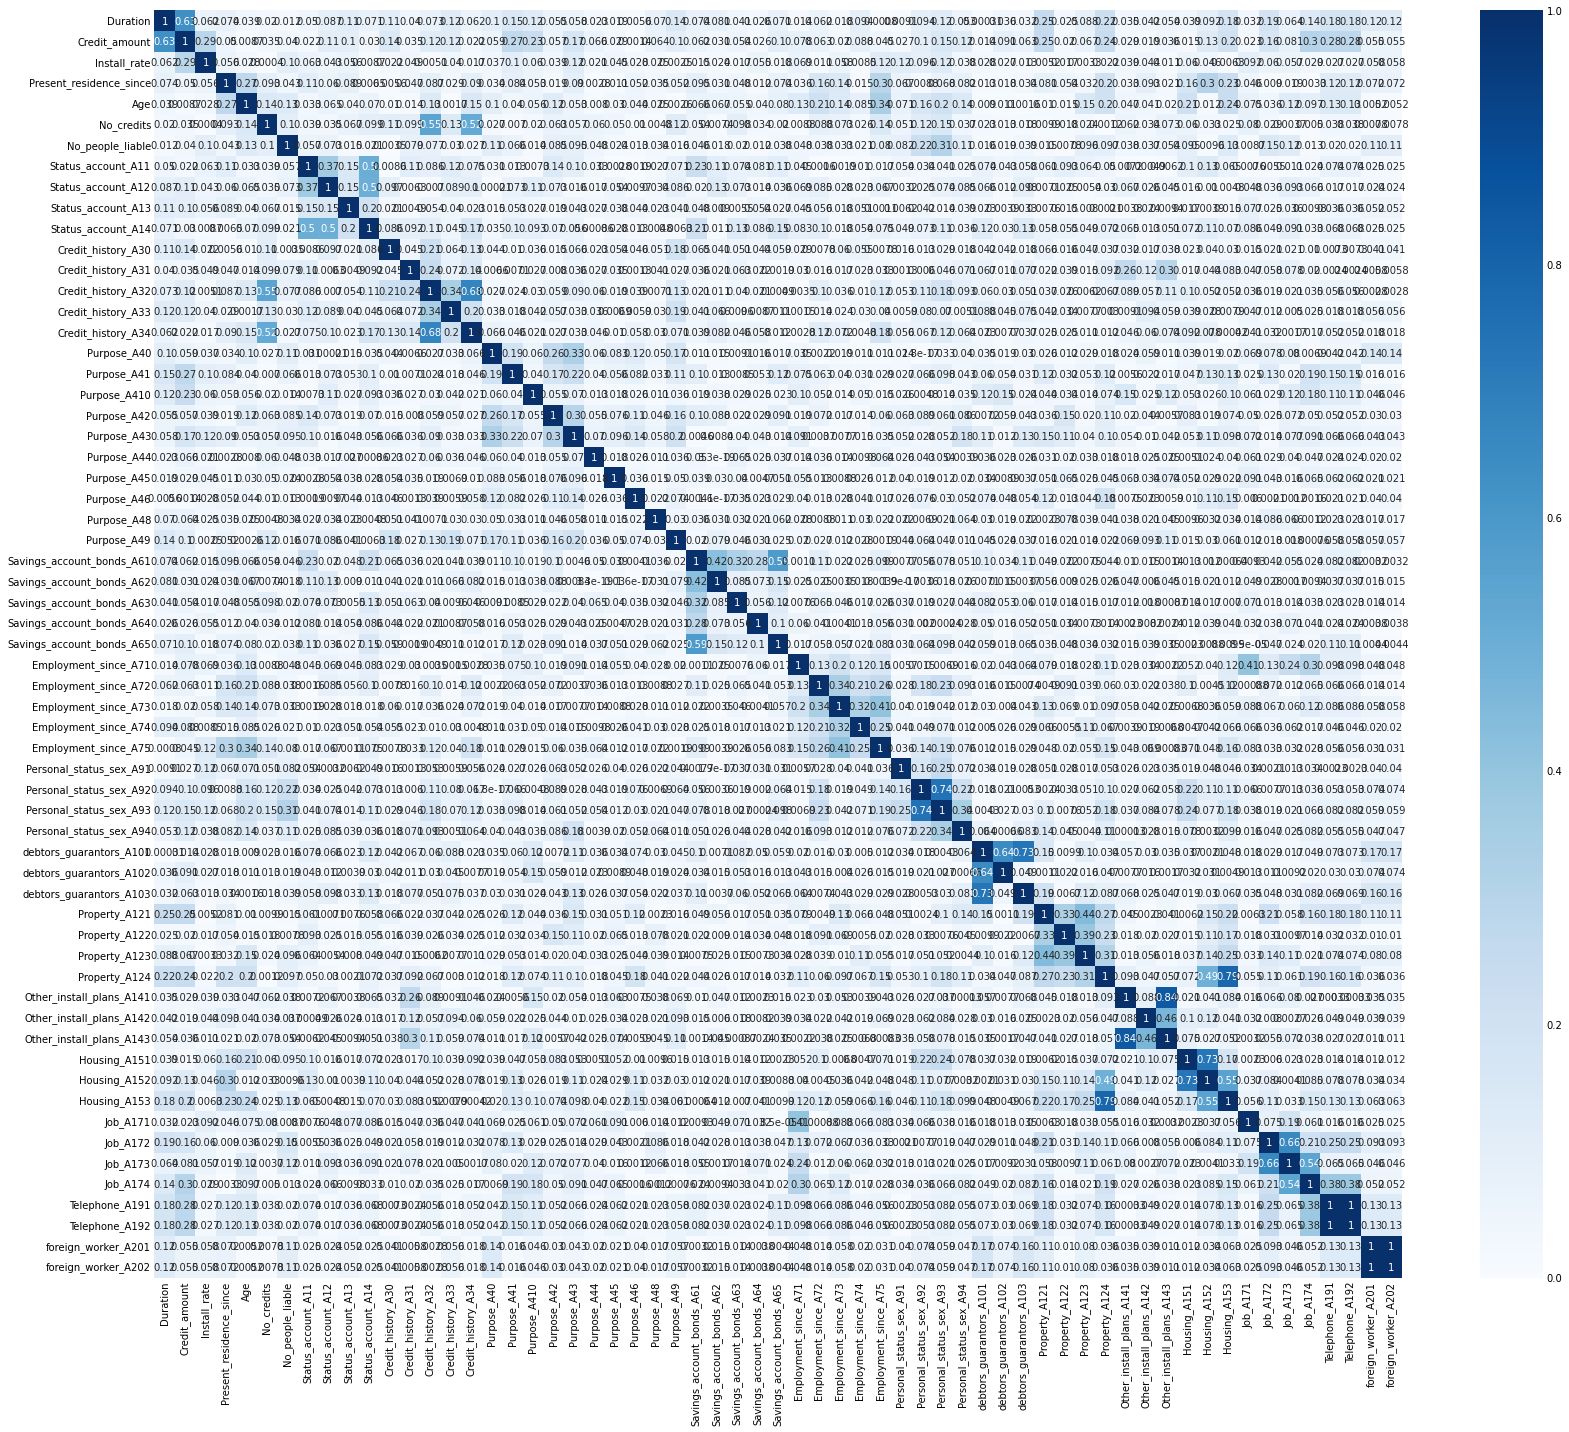

In [10]:
#### Apply dimensionality reduction techniques: t-Distributed Stochastic Neighbor Embedding (t-SNE)
#### and Principal Component Analysis (PCA) to reduce and visualize the data.

#### I compute the correlation between the features to see if there are any correlated features
correlation_analysis = X.corr().abs()

plt.figure(figsize = (24,20))
sns.heatmap(correlation_analysis, cmap="Blues", annot=True)
plt.show

### 2.1.1 PCA

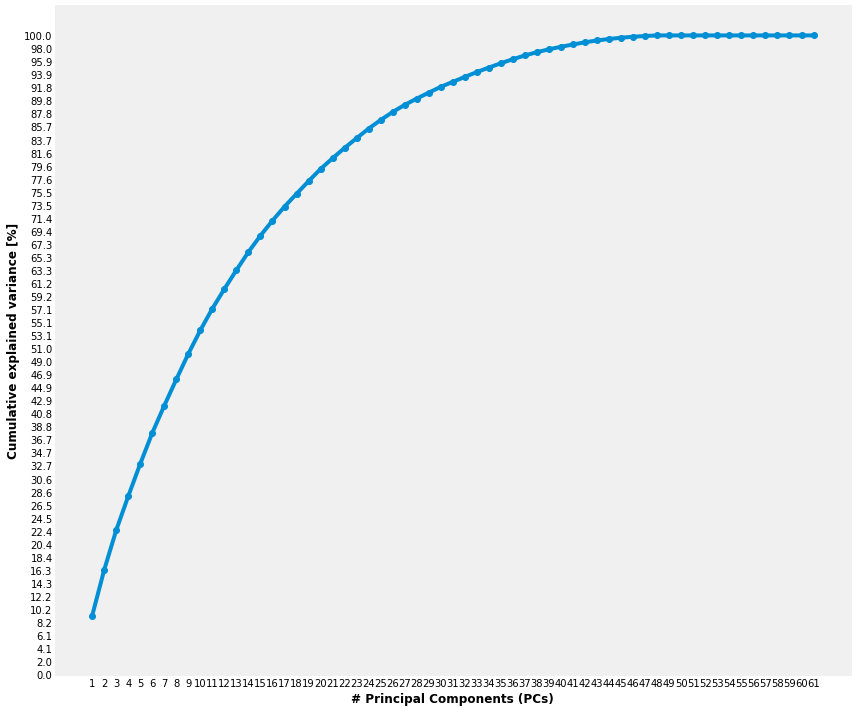

0 : 9.157925436517077
1 : 16.323037261819735
2 : 22.54426291088664
3 : 27.862541556699444
4 : 32.94708626906171
5 : 37.76963173274768
6 : 42.05501688785597
7 : 46.163091269312616
8 : 50.16518130979779
9 : 53.85589579703329
10 : 57.242230796197546
11 : 60.319868016777846
12 : 63.271479245556336
13 : 66.1043558062183
14 : 68.66213761122967
15 : 71.00781886609332
16 : 73.20527782094273
17 : 75.20106141435025
18 : 77.18927903020867
19 : 79.09519774604496
20 : 80.77688582389302
21 : 82.39445953608762
22 : 83.92281784646674
23 : 85.41446434379544
24 : 86.76234104335322
25 : 88.01573238041208
26 : 89.13042121930854
27 : 90.11254457673417
28 : 91.04547946373943
29 : 91.95184123160233
30 : 92.7352194251198
31 : 93.51122957381116
32 : 94.26563197582533
33 : 94.97097371924619
34 : 95.64966133527369
35 : 96.28016903773513
36 : 96.86731042603873
37 : 97.38569133667396
38 : 97.82611836609343
39 : 98.22865557231401
40 : 98.58359475092962
41 : 98.9300912055982
42 : 99.21209209891762
43 : 99.4434284852

In [11]:
#### PCA to check the variances

pca = PCA(random_state=15)
pca.fit(X)

#### Here i compute the variability of the dataset, while the varaible number keeps increasing, 
#### until reaching all the number
explained_variance = pca.explained_variance_ratio_

#### This allows to represent the sum for each step (remember 61 features)
cum_exp_var = np.cumsum(explained_variance)

#### Representing it in percentage
perc_cum_exp_var = cum_exp_var * 100

#### Make the plot of cumulative explained variance w.r.t. number of components
plt.figure(figsize=(12, 10))
plt.plot(perc_cum_exp_var, marker='o')
plt.xlabel('# Principal Components (PCs)')
plt.ylabel('Cumulative explained variance [%]')
plt.xticks([i for i in range(61)], [i for i in range(1,62)])
plt.yticks(np.linspace(0,100, 50))
plt.grid()
plt.tight_layout()
plt.show()

for i in range (len(perc_cum_exp_var)):
    print(i, ":", perc_cum_exp_var[i])

### SMOTE for oversampling

In [12]:
sm = SMOTE(random_state=60)
X_res, y_res = sm.fit_resample(X, y)

In [13]:
#### I choose 47 components because I'll be able to describe 100% of the dataset
pca = PCA(n_components = 30)
pca.fit(X_res)

X_PCA = pca.transform(X_res)
X_test_PCA = pca.transform(X_test)

<function matplotlib.pyplot.show(close=None, block=None)>

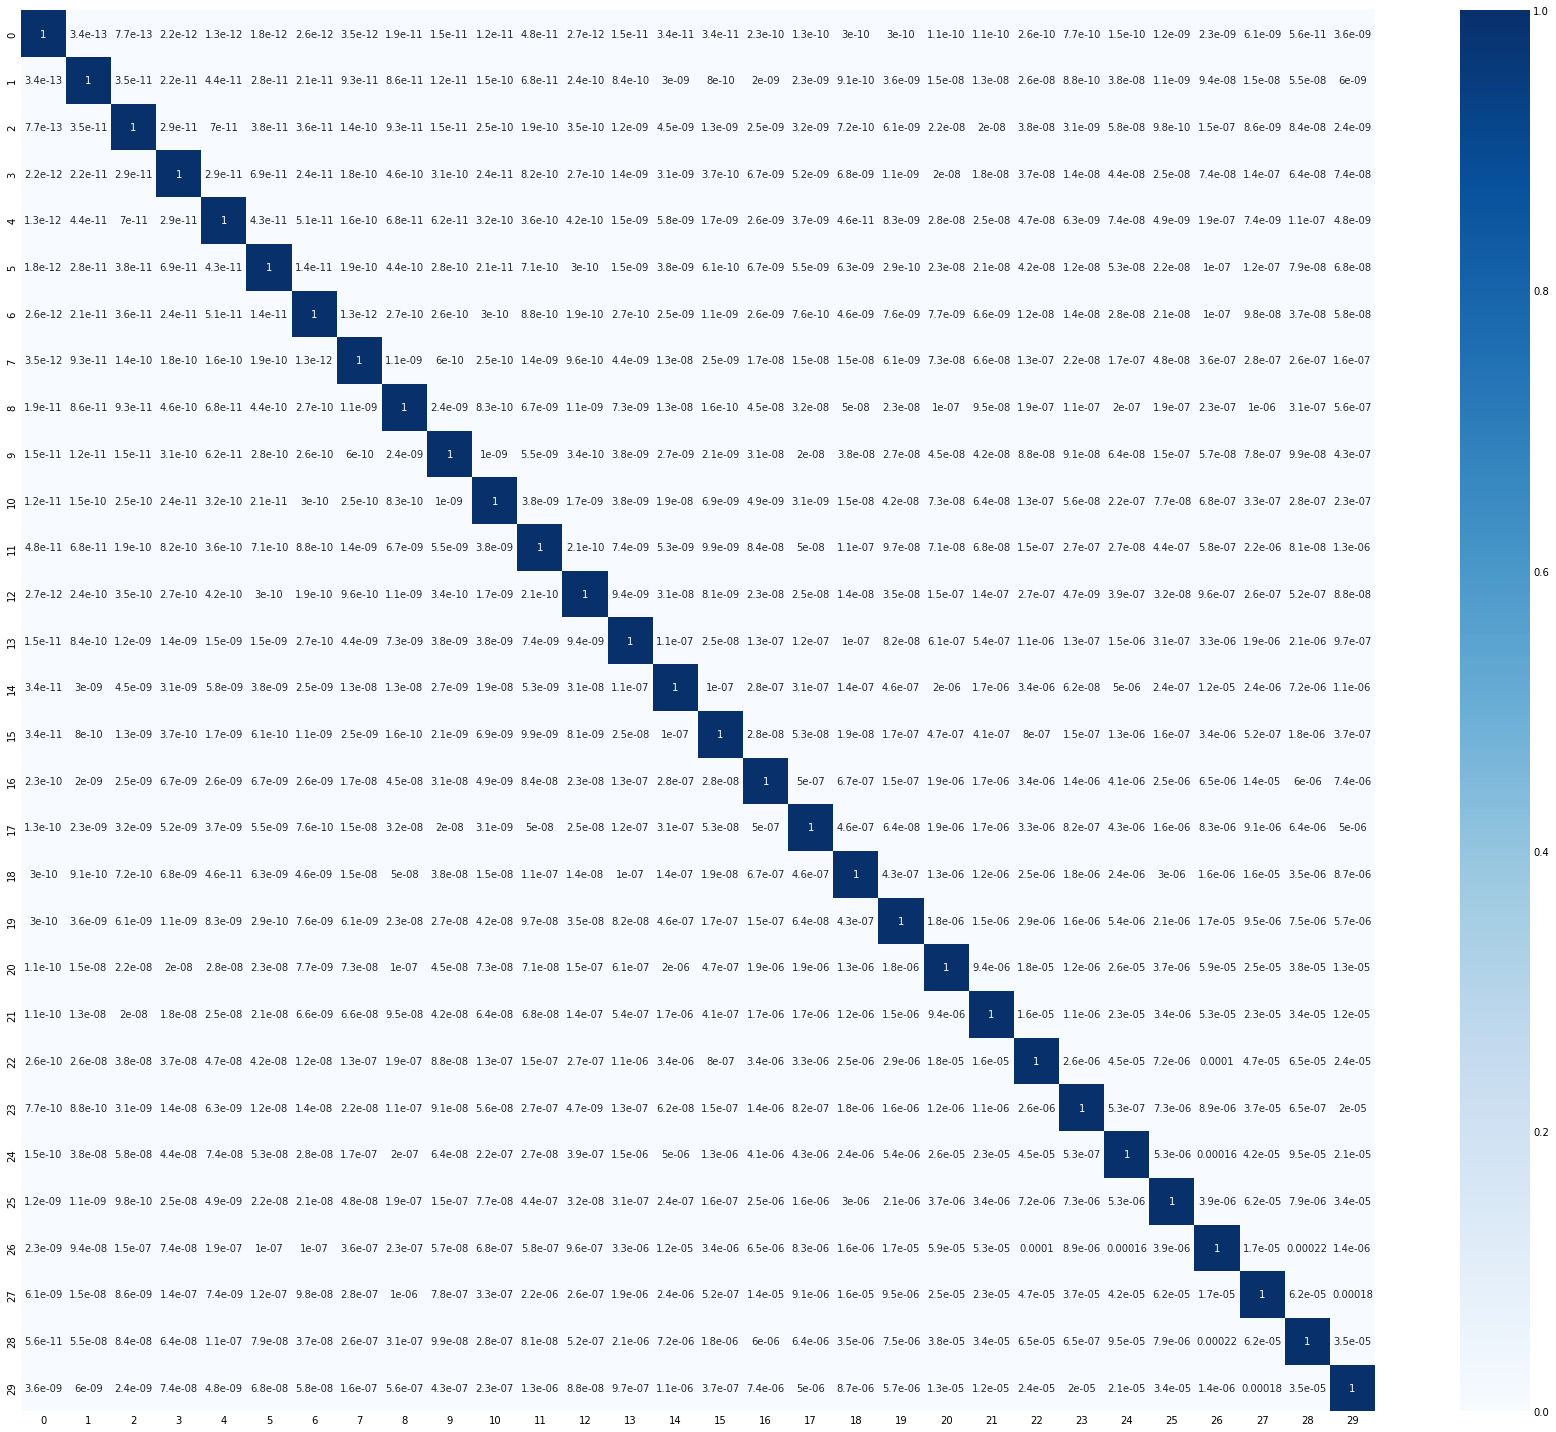

In [15]:
####Compute the correlation matrix after PCA
correlation_analysis = pd.DataFrame(X_PCA).corr().abs()
plt.figure(figsize = (24,20))
sns.heatmap(correlation_analysis, cmap="Blues", annot=True)
plt.show

#### No more correlation between different features after PCA
#### X is the transformed training dataset using PCA, it will have 45 features, 
#### with a total variance of the dataset of 99,78%

### 2.1.2 T-sne

In [16]:
#### I Apply t-SNE for dimensionality reduction
perplexities = [5, 10, 20, 30, 50]
learning_rate = np.linspace(10, 1000, 5)

plt.figure(figsize=(15, 10))

for i, perplexity in enumerate(perplexities, 1):
    for lr in learning_rate:
        tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42, learning_rate = lr)
        X_tsne = tsne.fit_transform(X[X_encoded.columns])
        if (perplexity == 5 and lr == 10):
            transformed_df_t_sne = pd.DataFrame(X_tsne, columns = ['C1', 'C2'])

        # scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
        # plt.title(f't-SNE Visualization (Perplexity={perplexity}, Learning Rate={lr})')
        # plt.show()

transformed_df_t_sne

,C1,C2
0,6.205675,0.818944
1,-54.767479,-11.684712
2,57.146175,-1.132252
3,-11.682610,45.248863
4,56.019215,33.122780
...,...,...
795,33.794113,27.352081
796,65.468628,20.466789
797,-23.973745,-7.632000
798,42.325092,2.476051


<Figure size 1080x720 with 0 Axes>

## 2.2 Unsupervised Data Analysis
---
### For practical reason we move the  Unsupervised Data Analysis [to another file](./Adversial%20Attack%20Unsupervised%20Data%20Analyis.ipynb)

#     3 Supervised Data Analysis

### 3.1 Classifier Selection
We choose from various classifiers, notably:
- Decision Tree classifier
- Gaussian Naive Bayes classifier
- K-Nearest Neighbors classifier
- Support Vector Machines classifier
- Logistic regressor
- Neural Networks 

### 3.2 Cross-Validation

#### Here we consider non NN classifiers

In [ ]:
best = 0
DT_parameters = {"criterion":['gini', 'entropy'], 'max_depth':[None, 4, 6, 8, 10, 12, 14], 'min_samples_split':[2, 3, 4, 5, 6, 7, 8]}
GNB_parameters = {"var_smoothing": (np.logspace(-9,0,10))}
KNN_parameters = {"n_neighbors": range(1,31), "weights": ['uniform','distance'], "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute']}
SVM_parameters = {"kernel": ['linear', 'poly', 'rbf', 'sigmoid'], "C": [100, 10, 1.0, 0.1, 0.001]}
LR_parameters = {"penalty": ['l1', 'l2', 'elasticnet', None], "solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], "C": [100, 10, 1.0, 0.1, 0.01], "max_iter": [200]}
classifiers = [{"classifier": DecisionTreeClassifier, "parameters": DT_parameters}, {"classifier": GaussianNB, "parameters": GNB_parameters},
               {"classifier": KNeighborsClassifier, "parameters": KNN_parameters}, {"classifier": svm.SVC, "parameters": SVM_parameters}, 
               {"classifier": LogisticRegression, "parameters": LR_parameters}]

for classifier in classifiers:
    clf = GridSearchCV(classifier["classifier"](), classifier["parameters"], cv = StratifiedKFold(n_splits=20), scoring = 'accuracy', n_jobs=10)
    clf.fit(X_PCA, y_res)
    if (clf.best_score_ > best):
        best = clf.best_score_
        best_clf = clf
        best_clf_param = list(classifier["parameters"].keys())
        best_clf_name = classifier["classifier"]
        best_clf_score = clf.best_score_
    print("Best Score for " + str(classifier["classifier"]()).replace("()","") + ":", clf.best_score_)
    print("Best Parameters ", clf.best_params_,"\n")

print("\nBest Classifier: " + str(best_clf_name()).replace("()",""))
print("Best Score: ",best_clf_score)

NameError: name 'np' is not defined

['kernel', 'C']


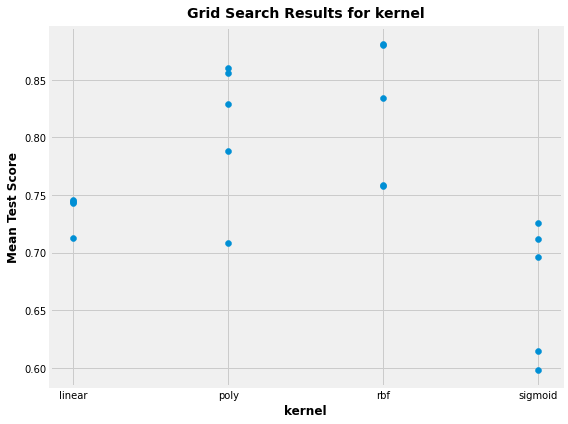

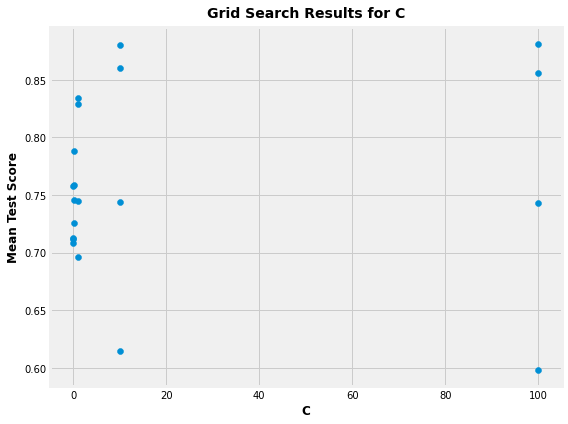

In [ ]:
def plot_grid_search(cv_results, param_name, scoring=None):
    if scoring is None:
        scoring = list(cv_results['mean_test_score'])[0]
        
    # Extract the mean test scores and the parameter values
    mean_test_scores = cv_results['mean_test_score']
    param_values = cv_results['param_' + param_name].data

    # Sort the parameter values and corresponding test scores
    sorted_indices = np.argsort(param_values)
    sorted_param_values = np.array(param_values)[sorted_indices]
    sorted_mean_test_scores = np.array(mean_test_scores)[sorted_indices]

    plt.figure(figsize=(8, 6))
    plt.scatter(sorted_param_values, sorted_mean_test_scores, marker='o')
    plt.xlabel(param_name)
    plt.ylabel('Mean Test Score')
    plt.title(f'Grid Search Results for {param_name}')
    plt.grid(True)
    plt.show()

print(best_clf_param)
for i in range(len(best_clf_param)):
    plot_grid_search(best_clf.cv_results_, best_clf_param[i])


#### Here we consider the Neural Network part, first split the dataset into train, validation and test sets and convert them to pytorch tensors

In [ ]:
print(f"X is: {len(X_res)}")
print(f"y is: {len(y_res)}")

X_train, X_val, y_train, y_val = train_test_split(
    X_PCA, y_res, 
    stratify=y_res, 
    train_size=0.75, 
    random_state=10
)

print(f"X_train is: {len(X_train)}")
print(f"y_train is: {len(y_train)}")
print(f"X_val is: {len(X_val)}")
print(f"y_val is: {len(y_val)}")
print(f"X_test is: {len(X_test)}")
print(f"y_test is: {len(y_test)}")

#### transform numpy array to pytorch tensor
X_train_t = torch.tensor(X_train, dtype=torch.float)
print(X_train_t.shape)
y_train_t = torch.tensor(np.ravel(y_train), dtype=torch.long)
print(y_train_t.shape)
X_val_t = torch.tensor(X_val, dtype=torch.float)
print(X_val_t.shape)
y_val_t = torch.tensor(np.ravel(y_val), dtype=torch.long)
print(y_val_t.shape)
X_test_t = torch.tensor(X_test_PCA, dtype=torch.float)
print(X_test_t.shape)
y_test_t = torch.tensor(np.ravel(y_test), dtype=torch.long)
print(y_test_t.shape)

X is: 1120
y is: 1120
X_train is: 840
y_train is: 840
X_val is: 280
y_val is: 280
X_test is: 200
y_test is: 200
torch.Size([840, 30])
torch.Size([840])
torch.Size([280, 30])
torch.Size([280])
torch.Size([200, 30])
torch.Size([200])


#### Definition of Neural Network model

In [ ]:
class Model_classification_multi(nn.Module): 

    def __init__(self, in_features, out_features, hidden_1, hidden_2, hidden_3, act):
        super().__init__()

        # define the architecture of neural network
        self.layers = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=hidden_1),
            act,
            nn.Linear(in_features=hidden_1, out_features=hidden_2),
            act,
            nn.Linear(in_features=hidden_2, out_features=hidden_3),
            act,
            nn.Linear(in_features=hidden_3, out_features=out_features), 
        )

    #### define feedforward process
    def forward(self, x):
        out = F.sigmoid(self.layers(x))
        return out

#### define the loss function
loss_fn = nn.CrossEntropyLoss()

#### define the accuracy function
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred))
    return acc

#### Grid search for Neural Network model

In [ ]:
#defining the parameters for the grid search
n_possible_act = [nn.ReLU(), nn.Tanh()]
n_possible_nodes = [63,163,1063]
n_possible_lr = [ 1e-2,1e-4,1e-6 ]
epochs = 200
best_acc = 0
best_mode = {'act': None,'n_nodes': None,'lr': None}

for act in n_possible_act:
    for n_nodes in n_possible_nodes:
        for lr in n_possible_lr:
                        
            # set a random seed 
            torch.seed()

            # initialize the model with the correspoding parameters
            model = Model_classification_multi(
                in_features = X_train_t.shape[-1], 
                out_features = np.unique(y_train).shape[0], 
                hidden_1 = n_nodes, 
                hidden_2 = n_nodes,
                hidden_3 = n_nodes,
                act=act
            )

            # define the optimizer (pass the parameters (model) that you want to optimize, and the learning rate)
            optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

            print(f"\n***** Test with lr={lr}, n_nodes={n_nodes}, act={act} ****")
        
            loss_train_all = []
            loss_val_all = []
            loss_test_all = []
            acc_train_all = []
            acc_val_all = []
            acc_test_all = []
            best_avg = 0

            for epoch in range(epochs):
                
                # model training phase
                model.train()
                y_prob = model(X_train_t).squeeze() # get the output probability of predictions
                loss = loss_fn(y_prob, y_train_t) # calculate the loss
                optimizer.zero_grad() # reset the gradients of model parameters
                loss.backward() # backpropagate the prediction loss
                optimizer.step() # adjust the parameters by the gradients 

                # model evaluation phase
                model.eval()

                # training set
                y_prob = model(X_train_t).squeeze()
                y_pred = torch.argmax(y_prob, dim=-1) # get the label
                acc_train = accuracy_fn(y_true=y_train_t, y_pred=y_pred)

                # validation set
                y_prob = model(X_val_t).squeeze()
                loss_val = loss_fn(y_prob, y_val_t) 
                y_pred = torch.argmax(y_prob, dim=-1) 
                acc_val = accuracy_fn(y_true=y_val_t, y_pred=y_pred)

                # test set
                y_prob = model(X_test_t).squeeze()
                loss_test = loss_fn(y_prob, y_test_t) 
                y_pred = torch.argmax(y_prob, dim=-1) 
                acc_test = accuracy_fn(y_true=y_test_t, y_pred=y_pred)

                # collect results
                loss_train_all.append(loss.detach().numpy())
                loss_val_all.append(loss_val.item())
                loss_test_all.append(loss_test.item())
                acc_train_all.append(acc_train)
                acc_val_all.append(acc_val)
                acc_test_all.append(acc_test)
                
                if(acc_val > best_acc):
                    best_acc = acc_val
                    best_mode["act"] = act
                    best_mode["n_nodes"] = n_nodes
                    best_mode["lr"] = lr

                if (epoch%50 == 0): 
                    print(f'\nEpoch: {epoch} |\n Train Loss: {loss:.5f}, Val Loss: {loss_val:.5f}, Test Loss: {loss_test:.5f},\n Train Acc: {acc_train:.2f}, Val Acc: {acc_val:.2f}, Test Acc: {acc_test:.2f}')
                    
print(f'Best Combination of Parameters : Activation Function={best_mode["act"]}, Number of Nodes={best_mode["n_nodes"]}, Learning Rate={best_mode["lr"]}')
print(f'Best Validation Accuracy = {best_acc}')


***** Test with lr=0.01, n_nodes=63, act=ReLU() ****

Epoch: 0 |
 Train Loss: 0.69312, Val Loss: 0.68995, Test Loss: 0.69481,
 Train Acc: 0.55, Val Acc: 0.53, Test Acc: 0.34

Epoch: 50 |
 Train Loss: 0.40976, Val Loss: 0.49924, Test Loss: 0.65819,
 Train Acc: 0.90, Val Acc: 0.81, Test Acc: 0.66

Epoch: 100 |
 Train Loss: 0.40728, Val Loss: 0.49830, Test Loss: 0.64728,
 Train Acc: 0.91, Val Acc: 0.81, Test Acc: 0.67

Epoch: 150 |
 Train Loss: 0.40612, Val Loss: 0.49532, Test Loss: 0.66698,
 Train Acc: 0.91, Val Acc: 0.82, Test Acc: 0.64

***** Test with lr=0.0001, n_nodes=63, act=ReLU() ****

Epoch: 0 |
 Train Loss: 0.69357, Val Loss: 0.69375, Test Loss: 0.70135,
 Train Acc: 0.50, Val Acc: 0.50, Test Acc: 0.30

Epoch: 50 |
 Train Loss: 0.69176, Val Loss: 0.69216, Test Loss: 0.69812,
 Train Acc: 0.50, Val Acc: 0.50, Test Acc: 0.30

Epoch: 100 |
 Train Loss: 0.68634, Val Loss: 0.68727, Test Loss: 0.69087,
 Train Acc: 0.72, Val Acc: 0.70, Test Acc: 0.55

Epoch: 150 |
 Train Loss: 0.67024,

### 3.3 Classifier Evaluation

#### Non-NN Classifier

In [ ]:
#### From the Cross-Validation analysis I take the best classifier and test it over the Test set
print(f'Using classifier : {best_clf_name()}')
clf_final = best_clf_name(**best_clf.best_params_)
clf_final.fit(X_PCA, y_res)
y_pred = clf_final.predict(X_test_PCA)

#### Classification report
print(classification_report(y_test, y_pred))

#### Get the confusion matrix of test set
confusion = confusion_matrix(y_test, y_pred)

#### Visualize the confusion matrix (representing the correct/not correct predictions)
plt.figure(figsize=(5,4))
sns.heatmap(confusion, cmap='Blues', annot=True, cbar_kws={'label':'Occurrences'}, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.show()

#### ROC Curve
RocCurveDisplay.from_estimator(clf_final, X_test_PCA, y_test)
plt.show()  

#### Neural Network

In [ ]:
#defining the best parameters found with the grid search
n_possible_act = [best_mode['act']]
n_possible_nodes = [best_mode['n_nodes']]
n_possible_lr = [ best_mode['lr'] ]
epochs = 1100
best_acc = 0
best_mode = {'act': None,'n_nodes': None,'lr': None}

#define different possible starting points via the seed (starting point is crucial for a good nn)
possible_seeds = []

#tring only two for the sake of time
for i in range(2):
    random.seed()
    possible_seeds.append(random.randrange(-9223372036854775808, 18446744073709551615,1))

lock_acc_val = 0
for act in n_possible_act:
    for n_nodes in n_possible_nodes:
        for lr in n_possible_lr:
            for seed in possible_seeds:
                previous = 0
                epoch = 0
                # set the random seed 
                torch.manual_seed(seed)

                # initialize the model with the correspoding parameters
                model = Model_classification_multi(
                    in_features = X_train_t.shape[-1], 
                    out_features = np.unique(y_train).shape[0], 
                    hidden_1 = n_nodes, 
                    hidden_2 = n_nodes,
                    hidden_3 = n_nodes,
                    act=act
                )
                
                optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
                #optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

                print(f"\n***** Test with lr={lr}, n_nodes={n_nodes}, act={act} seed={seed} ****")

                while epoch < 1100:

                    if epoch == 1:
                        print(f'\nEpoch: {epoch} |\n Train Loss: {loss:.5f}, Val Loss: {loss_val:.5f}, Test Loss: {loss_test:.5f},\n Train Acc: {acc_train:.2f}, Val Acc: {acc_val:.2f}, Test Acc: {acc_test:.2f}')

                    # model training phase
                    model.train()
                    y_prob = model(X_train_t).squeeze() # get the output probability of predictions
                    loss = loss_fn(y_prob, y_train_t) # calculate the loss
                    optimizer.zero_grad() # reset the gradients of model parameters
                    loss.backward() # backpropagate the prediction loss
                    optimizer.step() # adjust the parameters by the gradients 

                    # model evaluation phase
                    model.eval()

                    # training set
                    y_prob = model(X_train_t).squeeze()
                    y_pred = torch.argmax(y_prob, dim=-1) # get the label
                    acc_train = accuracy_fn(y_true=y_train_t, y_pred=y_pred)

                    # validation set
                    y_prob = model(X_val_t).squeeze()
                    loss_val = loss_fn(y_prob, y_val_t) 
                    y_pred = torch.argmax(y_prob, dim=-1) 
                    acc_val = accuracy_fn(y_true=y_val_t, y_pred=y_pred)

                    # test set
                    y_prob = model(X_test_t).squeeze()
                    loss_test = loss_fn(y_prob, y_test_t) 
                    y_pred = torch.argmax(y_prob, dim=-1) 
                    acc_test = accuracy_fn(y_true=y_test_t, y_pred=y_pred)

                    #every 30 epochs after the 50th, if the val_accuray stabilizes, stop the training.
                    if(epoch%30 == 0):
                        if(epoch > 50 and acc_val == previous):
                            print(f"lock acc_val = {acc_val}")
                            epoch = 1100
                            lock_acc_val = acc_val
                        previous = acc_val
                        
                    if(acc_val > best_acc):
                        best_acc = acc_val
                        best_mode["act"] = act
                        best_mode["n_nodes"] = n_nodes
                        best_mode["lr"] = lr
                        torch.save(model.state_dict(), "./CreditModel.model")
                    
                    #save the state of the model every 49 epochs in case of any crash
                    if (epoch%49 == 0): 
                        PATH = "model.pt"

                        torch.save({
                                    'epoch': epoch,
                                    'model_state_dict': model.state_dict(),
                                    'optimizer_state_dict': optimizer.state_dict(),
                                    'loss': loss,
                                    }, PATH)
                        print(f'\nEpoch: {epoch} |\n Train Loss: {loss:.5f}, Val Loss: {loss_val:.5f}, Test Loss: {loss_test:.5f},\n Train Acc: {acc_train:.2f}, Val Acc: {acc_val:.2f}, Test Acc: {acc_test:.2f}')
                    
                    epoch = epoch+1
                    
print(f'Best Validation Accuracy = {best_acc}')

In [ ]:
#### Validation set
model.load_state_dict(torch.load("./CreditModel.model"))
model.eval()
y_prob = model(X_val_t).squeeze()
y_pred = torch.argmax(y_prob, dim=-1) 
acc_val = accuracy_fn(y_true=y_val_t, y_pred=y_pred)
print(f'\nThe accuracy of validation set is: {acc_val:.3f}')
print(classification_report(y_val_t, y_pred))
confusion = confusion_matrix(y_val_t, y_pred)

#### Visualize the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion, cmap='Blues', annot=True, cbar_kws={'label':'Occurrences'}, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.show()

In [ ]:
#### Test set
model.eval()
y_prob = model(X_test_t).squeeze()
y_pred = torch.argmax(y_prob, dim=-1) 
acc_test = accuracy_fn(y_true=y_test_t, y_pred=y_pred)
print(f'\nThe accuracy of test set is: {acc_test:.3f}')
print(classification_report(y_test_t, y_pred))
confusion = confusion_matrix(y_test_t, y_pred)

#### Visualize the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion, cmap='Blues', annot=True, cbar_kws={'label':'Occurrences'}, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.show()

print(X_test_t.shape)

# 4 Adversarial Attack #

### 4.1 Adding Random Noise

In [ ]:
# Function to add noise to numerical data
def add_noise_with_norm_clipping(data, columns, noise_level):

    # Generate random noise with the same shape as the data
    noise = np.random.normal(size=data[columns].shape, loc=0, scale=noise_level*0.01)
    noise = pd.DataFrame(noise, index=data.index, columns=to_remove)

    # Calculate the Euclidean norm of the noise
    #noise_norm = np.linalg.norm(noise)

    # Clip the noise to have a certain Euclidean norm
    #if noise_norm > norm_threshold:
    #    noise = noise * (norm_threshold / noise_norm)

    # Add noise to the data
    temp = data[columns].copy()
    temp = temp + noise
    return temp

# Function to add noise to categorical data
def add_noise_to_categorical(df, columns, noise_level):

    for column in columns:
        unique_values = df[column].unique()
        num_samples = int(len(df) * noise_level * 0.01) # Noise Level between 0 and 100 meaning percentage of dataset to change
        indices_to_change = np.random.choice(df.index, num_samples, replace=False)

        for idx in indices_to_change:
            current_value = df.at[idx, column]
            new_value = np.random.choice(unique_values)

            # Ensure the new value is different from the current value
            #while new_value == current_value:
            #    new_value = np.random.choice(unique_values)

            df.at[idx, column] = new_value
    
    return df

accuracy = {}
# Specify the maximum Noise Level for the added noise
for noise_level in range(0, 100, 10):
    
    print(f'Results with Noise Level={noise_level}')

    # Add noise with a certain in noise level
    cat_Noisy = add_noise_to_categorical(X_test_not_encoded, to_be_encoded, noise_level)
    cat_Noisy = cat_Noisy.drop([col for col in cat_Noisy.columns if col in to_remove], axis=1)
    cat_Noisy = pd.get_dummies(cat_Noisy, columns=to_be_encoded, dtype = int)
    
    # Add noise to the data with Euclidean norm clipping
    num_Noisy = add_noise_with_norm_clipping(X_test.copy(), to_remove, noise_level)
    num_Noisy = num_Noisy.drop([col for col in num_Noisy.columns if col not in to_remove], axis=1)
    num_Noisy.index = cat_Noisy.index

    X_test_noisy = pd.concat([num_Noisy, cat_Noisy], axis=1)
    X_test_noisy = pca.transform(X_test_noisy)

    X_noisy_t = torch.tensor(X_test_noisy, dtype=torch.float)

    #### Test set
    model.eval()
    y_prob = model(X_noisy_t).squeeze()
    y_pred = torch.argmax(y_prob, dim=-1) 
    report = classification_report(y_test_t, y_pred, output_dict=True)
    print(classification_report(y_test_t, y_pred))
    accuracy[noise_level] = report
    confusion = confusion_matrix(y_test_t, y_pred)

    #### Visualize the confusion matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(confusion, cmap='Blues', annot=True, cbar_kws={'label':'Occurrences'}, fmt='d')
    plt.xlabel('Prediction')
    plt.ylabel('True')
    plt.title(f'Confusion matrix for Noise Level={noise_level}')
    plt.show()

fig, axs = plt.subplots(3,figsize=(10,11), tight_layout=True)
fig.suptitle('Changes in metrics with noise level change')

values=[]
for value in accuracy.values():
    values.append(value['0']['f1-score'])
axs[0].plot(accuracy.keys(), values)
axs[0].set_ylabel('0-Class F1-Score')
axs[0].set_xlabel('Noise Level')

values=[]
for value in accuracy.values():
    values.append(value['1']['f1-score'])
axs[1].plot(accuracy.keys(), values)
axs[1].set_ylabel('1-Class F1-Score')
axs[1].set_xlabel('Noise Level')

values=[]
for value in accuracy.values():
    values.append(value['accuracy'])
axs[2].plot(accuracy.keys(), values)
axs[2].set_ylabel('Accuracy')
axs[2].set_xlabel('Noise Level')


### 4.2 Feature specific noise

In [ ]:
# def l2_norm_dummy_encoded(x, x_adv, noise_level):
#     squared_diffs = np.sum((x - x_adv) ** 2)
#     l2 = np.sqrt(squared_diffs)

#     for key, value in l2.items():
#       if value:
#         print(key, ": ", value) 



def evaluate_accuracy(X_noisy, y_test):
    #### transform numpy array to pytorch tensor
    X_test_t = torch.tensor(X_noisy, dtype=torch.float)
    y_test_t = torch.tensor(np.ravel(y_test), dtype=torch.long)

    #### Test set
    model.eval()
    y_prob = model(X_test_t).squeeze()
    y_pred = torch.argmax(y_prob, dim=-1) 
    report = classification_report(y_test_t, y_pred, output_dict=True)
    confusion = confusion_matrix(y_test_t, y_pred)

    return report,confusion


# Function to add noise to categorical data
def add_noise_to_categorical(df, column, epsilon):
    unique_values = df[column].unique()
    num_samples = int(len(df) * epsilon) # Number of columns to change
    indices_to_change = np.random.choice(df.index, num_samples, replace=False)
    
    for idx in indices_to_change:
        # current_value = df.at[idx, column]
        new_value = np.random.choice(unique_values)
        df.at[idx, column] = new_value           # I don't verify if the values is picked the same to make it as random as possible
    return df



def add_noise_to_numerical(data, epsilon):
    # Generate random noise with the same shape as the data
    noise = np.random.normal(size=data.shape, loc=0, scale=epsilon)

    noisy_data = data.add(noise)

    return noisy_data


#######################################################################################################
# END OF FUNCTIONS PART
# BEGINNING OF THE CODE
#########################################################################################################

X_test_numerical = X_test[to_remove] # Taking only the numerical columns of the dataset

# Calculate accuracy with noise added
epsilons = np.linspace(0.1, 1, 10)  # Range of epsilon values to test

class0_f1score = []
class1_f1score = []
accuracy_noise_norm= []
for epsilon in epsilons:
    accuracy = {}
    print("Epsilon: ", epsilon)
    print("---------------------------------------------------------------------------------------------------------------------------------------------------")
    
    # Adding random noise to numerical features
    for num_column in to_remove:
        X_test_noised = X_test.copy() 
        column = add_noise_to_numerical(X_test[num_column], epsilon)
        X_test_noised[num_column] = column
        # print("Column: ", num_column)
        # l2_norm_dummy_encoded(X_test, X_test_noised,epsilon)
        X_test_noised = pca.transform(X_test_noised)
        report, confusion = evaluate_accuracy(X_test_noised, y_test)
        accuracy[num_column] = report
    
    # Adding random noise to categorical features = meaning randomly select all the possible values for each column for a precise number of rows (defined by noise_norm value)
    for cat_column in to_be_encoded:
        X_test_categorical = X_test_not_encoded.drop(columns=to_remove) # Create a copy of the dataset, removing the numerical columns
        X_test_categorical = add_noise_to_categorical(X_test_categorical, cat_column, epsilon) # This function will divide the noise between
                                                                                                                    #'0' and '1' 
                                                                                                                    #(0 = no rows get modified)
                                                                                                                    #(1 = all rows get modified)
        ### Using One Hot Encoding to transform categorical attributes into qualitative ones
        categorical_noised_dataset = pd.get_dummies(X_test_categorical, dtype = int) 
        
        X_test_numerical = X_test[to_remove] # This will be used only for concatenating
        X_test_numerical.index = categorical_noised_dataset.index
    
        # Unify the 2 noise addition to a signle dataset, called "X_test_noised"
        X_test_noised = pd.concat([X_test_numerical, categorical_noised_dataset], axis=1)
        X_test_noised = pca.transform(X_test_noised)
    
        report, confusion = evaluate_accuracy(X_test_noised, y_test)
        accuracy[cat_column] = report

    
    fig, axs = plt.subplots(3,figsize=(10,13), tight_layout=True)
    fig.suptitle('Changes in metrics with noised column changed')
    
    values=[]
    for value in accuracy.values():
        values.append(value['0']['f1-score'])
    axs[0].plot(accuracy.keys(), values, linestyle='solid', marker='o')   # X= Indices name of accuracy array         # Y= values of f1-score (0)
    axs[0].set_ylabel('0-Class F1-Score')
    axs[0].set_xlabel('Changed Column')
    axs[0].set_xticklabels(accuracy.keys(), rotation=80)  # Rotate x-axis labels
    
     ## I take the minimum value regardin the F1-Score (over the class 0) aspect, with the corrispective name
    min_value = min(values)
    min_key = values.index(min_value)
    min_key = list(accuracy.keys())[min_key]
    class0_f1score.append({'column': min_key, 'value': min_value})
    print("Min 0-Class F1-Score: ", min(values), "attribute: ", min_key)
    ######################################################################################################################################################
    values=[]
    for value in accuracy.values():
        values.append(value['1']['f1-score'])
    axs[1].plot(accuracy.keys(), values, linestyle='solid', marker='o')    # X= Indices name of accuracy array        # Y= values of f1-score (1)
    axs[1].set_ylabel('1-Class F1-Score')
    axs[1].set_xlabel('Changed Column')
    axs[1].set_xticklabels(accuracy.keys(),rotation=80)  # Rotate x-axis labels

    ## I take the minimum value regardin the F1-Score (over the class 1) aspect, with the corrispective name
    min_value = min(values)
    min_key = values.index(min_value)
    min_key = list(accuracy.keys())[min_key]
    class1_f1score.append({'column': min_key, 'value': min_value})
    print("Min 1-Class F1-Score: ", min(values), "attribute: ", min_key)
######################################################################################################################################################
    values=[]
    for value in accuracy.values():
        values.append(value['accuracy'])
    axs[2].plot(accuracy.keys(), values, linestyle='solid', marker='o')     # X= Indices name of accuracy array        # Y= values of accuracy
    axs[2].set_ylabel('Accuracy')
    axs[2].set_xlabel('Changed Column')
    axs[2].set_xticklabels(accuracy.keys(),rotation=80)  # Rotate x-axis labels

    ## I take the minimum value regardin the accuracy aspect, with the corrispective name
    min_value = min(values)
    min_key = values.index(min_value)
    min_key = list(accuracy.keys())[min_key]
    accuracy_noise_norm.append({'column': min_key, 'value': min_value})
    print("Min 1-Class F1-Score: ", min(values), "attribute: ", min_key)
######################################################################################################################################################
    plt.show()


In [ ]:
#################################################################################################################################
#Let's analyze the most vulnerable features using the 3 lists created before, containing the names and values of the columns 
#that received the lowest values of accuracy and f1-score changing the noise-norm

i = 0;
noise_norm = [i for i in range(1,16,2)]
most_frequent = []
class0_noColumn = []
class1_noColumn = []
accuracy_noColumn = []
for noise_norm_threshold in range(1, 16, 2):
    print("\nMost Vulnerable with max Noise-Norm: ", noise_norm_threshold)

    print("0-class f1-score\t", f"{class0_f1score[i]['column']}: {class0_f1score[i]['value']}")
    print("1-class f1-score\t", f"{class1_f1score[i]['column']}: {class1_f1score[i]['value']}")
    print("Accuracy\t\t", f"{accuracy_noise_norm[i]['column']}: {accuracy_noise_norm[i]['value']}")
    
    class0_noColumn.append(class0_f1score[i]['value'])
    class1_noColumn.append(class1_f1score[i]['value'])
    accuracy_noColumn.append(accuracy_noise_norm[i]['value'])

    most_frequent.append(class0_f1score[i]['column'])
    most_frequent.append(class1_f1score[i]['column'])
    most_frequent.append(accuracy_noise_norm[i]['column'])
    i += 1

# Count the occurrences among the lowest value of accuracy and f1-score and take the most_common, we will consider that value as the most vulnerable
element_count = Counter(most_frequent)
most_vulnerable_elements = element_count.most_common(1)
print("The most vulnerable feature is: ", most_vulnerable_elements)


# Plot the relationship between f1-score (and accuracy) changing the value of the noise-norm, only for the lowest attributes
fig, axs = plt.subplots(3,figsize=(10,11), tight_layout=True)
fig.suptitle('Changes in metrics with noise norm change')

axs[0].plot(noise_norm, class0_noColumn)
axs[0].set_ylabel('0-Class F1-Score')
axs[0].set_xlabel('Noise Norm')

axs[1].plot(noise_norm, class1_noColumn)
axs[1].set_ylabel('1-Class F1-Score')
axs[1].set_xlabel('Noise Norm')

axs[2].plot(noise_norm, accuracy_noColumn)
axs[2].set_ylabel('Accuracy')
axs[2].set_xlabel('Noise Norm')

plt.show()

### 4.3 Adversarial Attack using ART

In [ ]:

classifier = PyTorchClassifier(
    model=model,
    loss=loss_fn,
    optimizer=optimizer,
    input_shape=X_train_t.shape[-1],
    nb_classes=2,
    clip_values=(0, 1)
)


In [ ]:
## Attack 1: Fast Gradient Method (FGM)
#fgm = FastGradientMethod(estimator=classifier, eps=0.2)
#x_test_adv_fgm = []
#y_test_adv_fgm = []
#for images, labels in test_loader:
#    x_test_adv_fgm.append(fgm.generate(x=images.numpy()))
#    y_test_adv_fgm.append(labels.numpy())
#x_test_adv_fgm = np.vstack(x_test_adv_fgm)
#y_test_adv_fgm = np.hstack(y_test_adv_fgm)
#fgm_accuracy = np.sum(np.argmax(classifier.predict(x_test_adv_fgm), axis=1) == y_test_adv_fgm) / len(y_test_adv_fgm)
#print(f'Accuracy on FGM adversarial test data: {fgm_accuracy * 100:.2f}%')
#

In [ ]:
## Attack 2: Projected Gradient Descent (PGD)
#pgd = ProjectedGradientDescent(estimator=classifier, eps=0.2, eps_step=0.01, max_iter=40)
#x_test_adv_pgd = []
#y_test_adv_pgd = []
#for images, labels in test_loader:
#    x_test_adv_pgd.append(pgd.generate(x=images.numpy()))
#    y_test_adv_pgd.append(labels.numpy())
#x_test_adv_pgd = np.vstack(x_test_adv_pgd)
#y_test_adv_pgd = np.hstack(y_test_adv_pgd)
#pgd_accuracy = np.sum(np.argmax(classifier.predict(x_test_adv_pgd), axis=1) == y_test_adv_pgd) / len(y_test_adv_pgd)
#print(f'Accuracy on PGD adversarial test data: {pgd_accuracy * 100:.2f}%')


### 4.4 Countermeasures Exploration